[Website](https://jiji.ng/cars)

### Objective
The primary goal of this project is to extract, clean, and analyze car listing data scraped from Jiji.ng, a popular online marketplace in Nigeria. The project aims to derive actionable insights about the car market in Nigeria, including trends in pricing, vehicle features, and market dynamics.

### Importing necessary Libraries
- requests to send HTTP requests easily, such as GET, to interact with or retrieve web pages

- pandas for data handling, cleaning, manipulation and analysis.
- BeautifulSoup for parsing HTML and XML documents to extract specific data elements using a tree-like structure.
- selenium automates web browsers and user interaction like clicking buttons or dynamically waiting for items to load.
    - Service manages the ChromeDriver service for Selenium to interact with the Chrome browse

    - By provides methods to locate elements on a webpage (e.g., by ID, name, class name, etc.).
    - WebDriverWait explicitly waits for specific conditions to be met before proceeding with browser actions.
    - expected_conditions provides a collection of pre-built conditions for WebDriverWait (e.g., element visibility, clickability).
- time provides time-related functions like adding delays (e.g., time.sleep()), and working with timestamps, or measuring execution time.
- tqdm for visualizing the progress of loops in data processing or web scraping.
- json for serializing Python objects into JSON format.

In [1]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
from tqdm import tqdm
import json
import matplotlib.pyplot as plt
import seaborn as sns

### Scraping Car Data

This page incorporates the infinite scroller phenomenon so the logic starts with:
    
- scrolling as far as possible and then 
- looping through all items (cars) loaded to extract their links (href) and finally
- visiting each link one by one to extract car data as needed

The conversion to csv after each iteration is very much intentional as any Exception (eg HTML Timeout) will result in losing any previous data extracted.

In [ ]:
url = "https://jiji.ng/cars"
response = requests.get(url)

path = "C:/Users/HP/Downloads/chromedriver-win64/chromedriver.exe"

service = Service(path)
driver = webdriver.Chrome(service=service)

driver.get(url)

SCROLL_PAUSE_TIME = 0.2

last_height = driver.execute_script("return document.body.scrollHeight")

for i in tqdm(range(1500), desc='Scroller'):
    scroll_height =  driver.execute_script("return document.body.scrollHeight") *3
    driver.execute_script("window.scrollTo(0,  document.body.scrollHeight);")
    time.sleep(SCROLL_PAUSE_TIME)
    new_height = driver.execute_script("return document.body.scrollHeight")

cars = []

total_cars=0
all_cars_hrefs = []

frames = [link.get_attribute('href') for link in driver.find_elements(By.XPATH, "//a[@href][ancestor::*[contains(@class, 'b-list-advert__gallery__item')]]")]
all_cars_hrefs.extend(frames)

with tqdm(total=len(all_cars_hrefs), desc="Scraping Cars' Data") as pbar:
    try:
        for frame in frames: 
            driver.get(frame)
            time.sleep(5)

            page_source = driver.page_source
            soup = BeautifulSoup(page_source, 'html.parser')

            specs = {}

            try:
                show_more = WebDriverWait(driver, 10).until(
                EC.element_to_be_clickable((By.XPATH, "//button[@class='fw-button qa-fw-button fw-button--type-primary-link-like fw-button--size-small']"))
                )
                show_more.click()  
                time.sleep(1)
            except:
                pass

            caption = soup.find_all('div', class_='b-advert-attribute__key')
            header = [cap.text.strip() for cap in caption]

            value = soup.find_all('div', class_='b-advert-attribute__value')
            body = [val.text.strip() for val in value]
            item = [b.replace('\n', '').replace('     ', '').strip() for b in body]

            key, value = header, item
            specs = dict(zip(header, item))

            price_element = driver.find_element(By.XPATH, '//div[@itemprop="price"]')
            price_content = price_element.get_attribute("content")
            specs['Price'] = float(price_content)

            region = soup.find('div', class_='b-advert-info-statistics b-advert-info-statistics--region')
            if region:  
                where = region.text.strip().split(',')[0]
                specs['Location'] = where
            else:
                specs['Location'] = 'Unknown' 

            cars.append(specs)
            total_cars +=1
            pbar.update(1)

            df = pd.DataFrame(cars)
            df.to_csv('vroomvroom.csv')
    except Exception as e:
        print(f"Error Processing {frame}': {e}")   

print(f"Successfully scraped {len(cars)} Cars across entire iteration.")

Store car data in JSON format

In [14]:
j_path = "vroomvroom.json"

with open(j_path, 'w') as file:
    json.dump(cars, file, indent=4)

print(f"Data successfully saved to {j_path}")

Data successfully saved to vroomvroom.json


### Data Description
The dataset comprises various attributes of cars listed on Jiji.ng, including but not limited to:

- Vehicle Details: Make, Model, Trim, Year of Manufacture, Body Type, Drivetrain, Engine Size, Number of Cylinders, Horse Power.

- Condition and Features: Second Condition, Interior Color, Number of Seats, Registered Car, and Exchange Possibility.
- Market Data: Price, Location, VIN/Chassis Number, Registered City, Selling Condition, Bought Condition.

In [15]:
df.head()

,Second Condition,Make,Model,Year of Manufacture,Trim,Body,Drivetrain,Engine Size,Number of Cylinders,Horse Power,...,Interior Color,Seats,Registered Car,Exchange Possible,Price,Location,VIN Chassis number,Registered city,Selling Condition,Bought Condition
0,No faults,Ford,Edge,2013,Limited 4dr AWD (3.5L 6cyl 6A),SUV,All Wheel,3500 cc,6,285 hp,...,Brown,5,No,No,12000000.0,Lagos,NaN,NaN,NaN,NaN
1,"No faults, Unpainted, Original parts",Nissan,Micra,2005,NaN,NaN,NaN,NaN,NaN,NaN,...,Other,NaN,No,Yes,4000000.0,Oyo,NaN,NaN,NaN,NaN
2,"First owner, First registration",Lexus,RX,2002,NaN,NaN,NaN,NaN,NaN,NaN,...,Beige,NaN,Yes,NaN,4200000.0,Rivers,NaN,NaN,NaN,NaN
3,NaN,BMW,7 Series,2009,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,12500000.0,Kaduna,NaN,NaN,NaN,NaN
4,No faults,Lexus,GX,2017,460 Luxury,SUV,4x4,4600 cc,8,301 hp,...,Other,7,No,NaN,58000000.0,Lagos,JTJBM7FXXH5******,NaN,NaN,NaN


### Data Visualization

In [2]:
df = pd.read_csv("vroomvroom.csv")
df.drop(["Unnamed: 0"], axis=1, inplace=True)
df.head()

,Make,Model,Year of Manufacture,Color,Price,Location,Trim,Drivetrain,Engine Size,Number of Cylinders,Horse Power,Interior Color,Seats,Registered Car,Second Condition,Body,Exchange Possible,VIN Chassis number
0,Mercedes-Benz,C180,2000,Blue,4000000.0,Kano,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Mercedes-Benz,E350,2014,Black,13500000.0,Abuja,Base 4Matic Sedan AWD (3.5L 6cyl 7A),All Wheel,3500cc,6.0,302hp,Brown,5,Yes,NaN,NaN,NaN,NaN
2,Toyota,Sienna,2012,Black,16999999.0,Lagos,SE 8 Passenger,Front Wheel,3500cc,6.0,270hp,Black,8,No,No faults,Minivan,No,NaN
3,Mercedes-Benz,GLE-Class,2021,Blue,190000000.0,Lagos,AMG GLE 53 4MATIC,All Wheel,3000cc,6.0,429hp,Other,5,No,No faults,SUV,NaN,NaN
4,Honda,Accord,2005,Silver,2800000.0,Kaduna,2.4 Type S Automatic,Front Wheel,NaN,NaN,NaN,Black,NaN,Yes,"First owner, First registration, No faults",NaN,NaN,NaN


...

What are the top 10 most common car makes in the dataset?

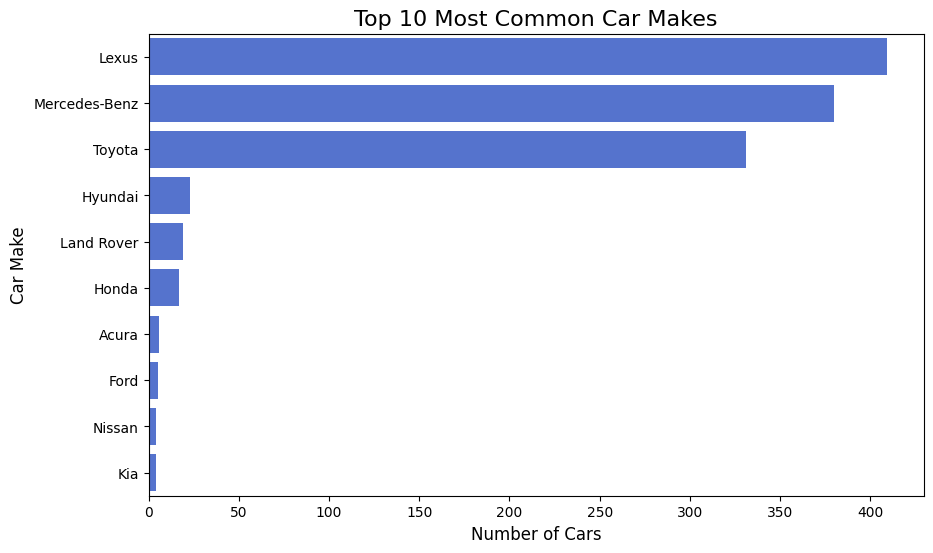

In [42]:
top_makes = df['Make'].value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_makes.values, y=top_makes.index, color='royalblue')
plt.title('Top 10 Most Common Car Makes', fontsize=16)
plt.xlabel('Number of Cars', fontsize=12)
plt.ylabel('Car Make', fontsize=12)
plt.show()

How does the price distribution vary across different car body types?

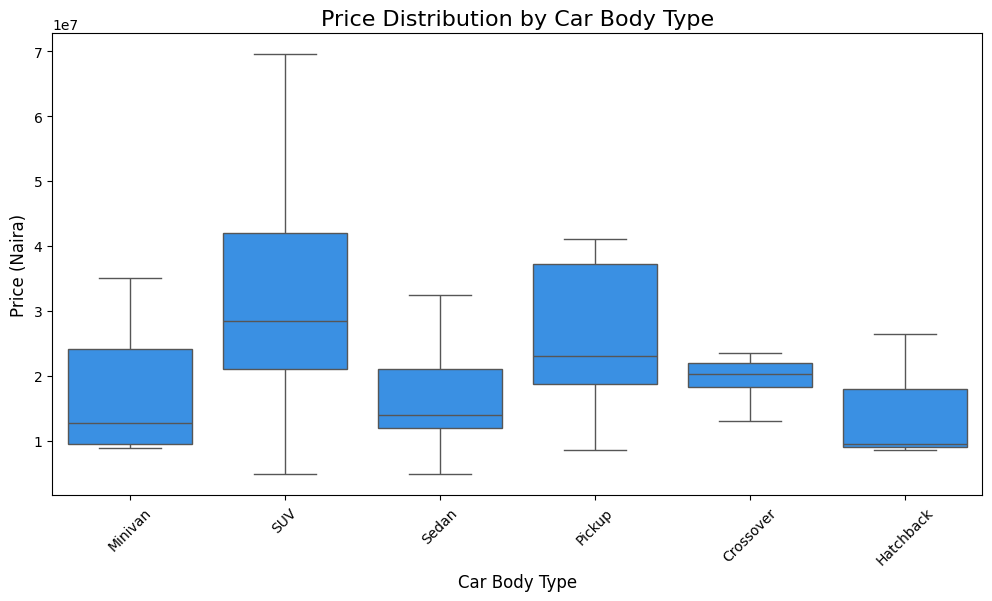

In [49]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Body', y='Price', color='dodgerblue',  showfliers=False)
plt.xticks(rotation=45)
plt.title('Price Distribution by Car Body Type', fontsize=16)
plt.xlabel('Car Body Type', fontsize=12)
plt.ylabel('Price (Naira)', fontsize=12)
plt.show()

What is the distribution of the year of manufacture of cars in the dataset?

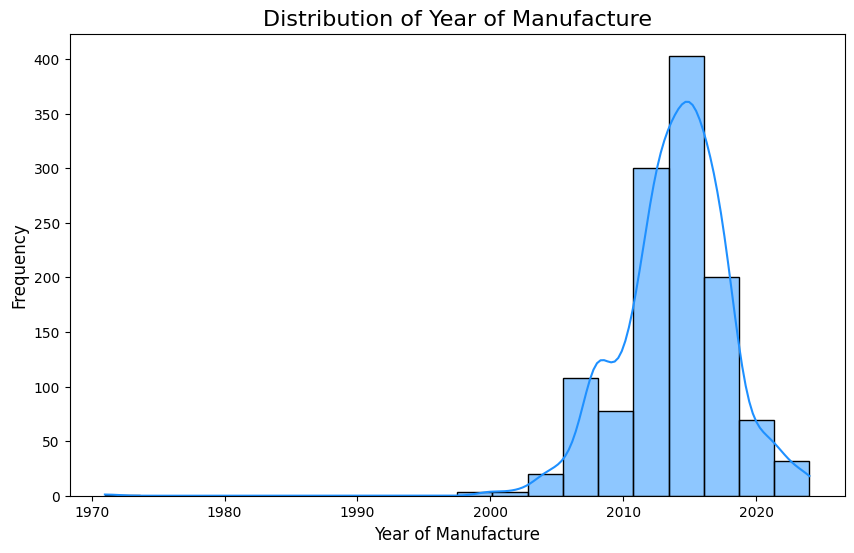

In [7]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Year of Manufacture'], bins=20, kde=True, color='dodgerblue')
plt.title('Distribution of Year of Manufacture', fontsize=16)
plt.xlabel('Year of Manufacture', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

What are the top 5 cities with the most registered cars?

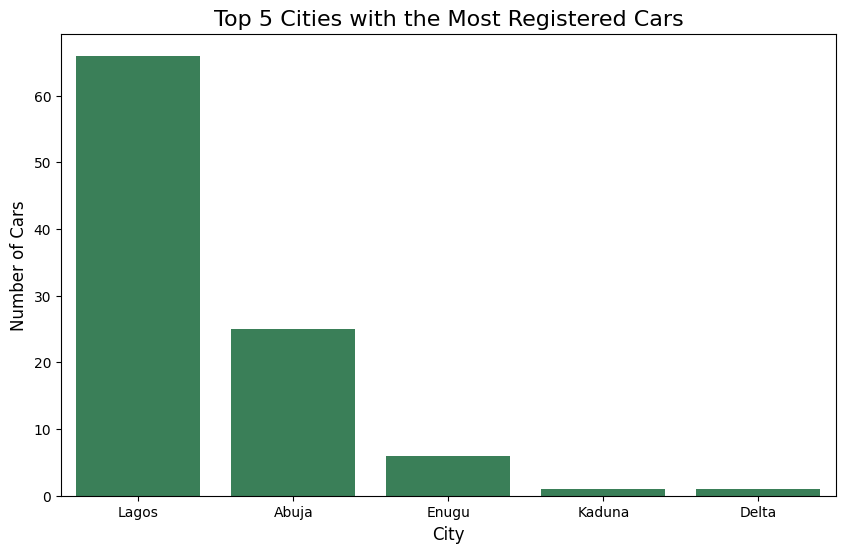

In [48]:
registered_cars = df[df['Registered Car'] == 'Yes']
top_cities = registered_cars['Location'].value_counts().head(5)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_cities.index, y=top_cities.values, color='seagreen')
plt.title('Top 5 Cities with the Most Registered Cars', fontsize=16)
plt.xlabel('City', fontsize=12)
plt.ylabel('Number of Cars', fontsize=12)
plt.show()